# EEG Motor Imagery Classification with ConvLSTM

This notebook implements the deep learning part of an EEG motor imagery classification pipeline.

The main preprocessing steps were carried out in **Matlab** and can be summarised as follows:

- **EOG artifact removal**  
  Eye movement artifacts were regressed out from the EEG channels using linear regression.
- **Band-pass filtering (2-60 Hz)**  
  Signals were filtered between 2 and 60 Hz to isolate the EEG frequency range.
- **Trial alignment**  
  The starting points of the trials were detected and corrected.
- **Artifact rejection**  
  Segments whose amplitude exceeded a given threshold were removed.

On top of these preprocessing steps, this notebook focuses on the **classification stage**:

- **Deep Learning (ConvLSTM)**  
  - Use the 3 pre-selected EEG channels during the motor imagery period (3 seconds).  
  - Augment each 3-second trial into 3 overlapping / non-overlapping 1-second crops.  
  - Reshape the data into a video-like tensor (frames × time-samples × channels) and train a ConvLSTM classifier.


#### 0. Imports and Global Settings 

In [ ]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

# Change this to your current project root:
PROJECT_ROOT = Path(r"C:\Users\elisa\Documents\elisa_projects\motor_imagery_EEG")
DATA_DIR = PROJECT_ROOT / "data"
MODEL_DIR = PROJECT_ROOT / "models"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT in sys.path:", PROJECT_ROOT in map(Path, sys.path))


PROJECT_ROOT in sys.path: True


In [ ]:
import datetime as dt
from src.utils_dl import (
    load_eeg_mat_dataset, augment_eeg_sequences, to_video_windows,build_conv_lstm, 
    train_and_save_model, majority_vote_over_crops, evaluate_classifier
)

from src.data_visualisation import plot_confusion_matrix, plot_training_curves

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score

from sklearn.metrics import (
    ConfusionMatrixDisplay,
)

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model


#### 1. Load training and test data

In [3]:
# Adjust paths as needed

train_mat_path = DATA_DIR / "training_set.mat"
test_mat_path  = DATA_DIR / "test_set.mat"

x_train, y_train = load_eeg_mat_dataset(train_mat_path, struct_name="training_set")
x_test, y_test = load_eeg_mat_dataset(test_mat_path, struct_name="test_set")

Loaded training_set from C:\Users\elisa\Documents\elisa_projects\motor_imagery_EEG\data\training_set.mat
  x shape: (399, 750, 3)
  y shape: (399,)
Loaded test_set from C:\Users\elisa\Documents\elisa_projects\motor_imagery_EEG\data\test_set.mat
  x shape: (307, 750, 3)
  y shape: (307,)


#### 2. Augment data 

I generate 3 sequences (1s each) out of the 3-second trial

In [4]:
n_channels = 3
f_sampling = 250
total_length = f_sampling * 3  # 3 seconds at 250 Hz
factor = 3          # number of crops per trial

x_train_aug, y_train_aug = augment_eeg_sequences(
    x_train, y_train, n_channels=n_channels, total_length=total_length, factor=factor
)

x_test_aug, y_test_aug = augment_eeg_sequences(
    x_test, y_test, n_channels=n_channels, total_length=total_length, factor=factor
)

Augmented data:
  x_aug shape: (1197, 250, 3)
  y_aug shape: (1197,)
Label distribution: Counter({np.uint8(0): 603, np.uint8(1): 594})
Augmented data:
  x_aug shape: (921, 250, 3)
  y_aug shape: (921,)
Label distribution: Counter({np.uint8(0): 462, np.uint8(1): 459})


#### 3. Convert to video windows

In [5]:
# 3 seconds -> 3 crops of 1 second -> 250 samples per crop
# frame_length = 50 samples (e.g. 100 ms at 500 Hz, or 200 ms at 250 Hz - adapt as needed)

frame_length = 50
crop_length = total_length // factor  # 250
n_frames = crop_length // frame_length  # 250 / 50 = 5

x_train_vid = to_video_windows(
    x_train_aug, n_frames=n_frames, frame_length=frame_length, n_channels=n_channels
)
x_test_vid = to_video_windows(
    x_test_aug, n_frames=n_frames, frame_length=frame_length, n_channels=n_channels
)

sequence_size = (n_frames, frame_length, n_channels)

Video-like representation:
  x_aug shape: (1197, 250, 3)
  x_vid shape: (1197, 5, 50, 3)
Video-like representation:
  x_aug shape: (921, 250, 3)
  x_vid shape: (921, 5, 50, 3)


#### 4. Build and inspect the model

In [6]:
model = build_conv_lstm(sequence_size)
model.summary()
plot_model(model, to_file="model_ConvLSTM.png", show_shapes=True, show_layer_names=True)

Model: "ConvLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 50, 3, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 48, 3, 16)   │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 5, 24, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 22, 3, 32)   │        18,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 11, 3, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 5, 9, 3, 64)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 5, 4, 3, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         3,841 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,713 (389.50 KB)

 Trainable params: 99,713 (389.50 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### 5. Train the model

Using GPU devices: []
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5272 - loss: 0.6931
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.6249 - loss: 0.6916
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6775 - loss: 0.6894
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7126 - loss: 0.6855
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7293 - loss: 0.6765
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7318 - loss: 0.6542
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7435 - loss: 0.6050
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7477 - loss: 0.5386
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7510 - loss: 0.5065
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7544 - loss: 0.4947
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7661 - loss: 0.4864
Epoch 12/100
19/19 ━━━━━━━━━━━

Model saved to: C:\Users\elisa\Documents\elisa_projects\motor_imagery_EEG\models\ConvLSTM_Date_Time_2025_11_09__19_57_43.h5
History saved to: C:\Users\elisa\Documents\elisa_projects\motor_imagery_EEG\models\ConvLSTM_history_2025_11_09__19_57_43.npy


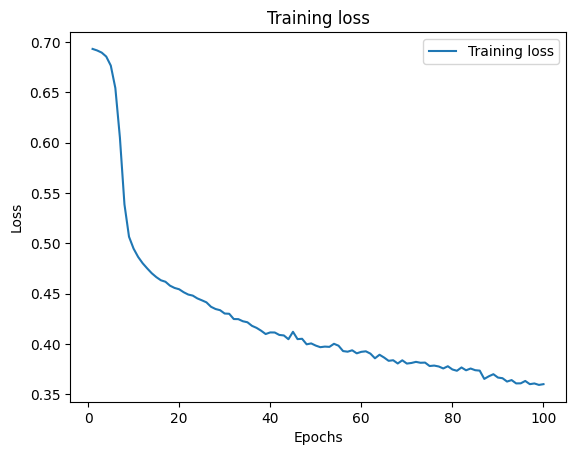

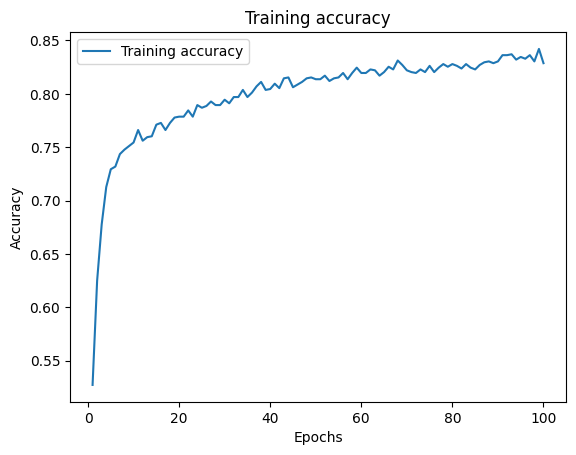

In [7]:
history, model_filename = train_and_save_model(
    model,
    x_train_vid,
    y_train_aug,
    batch_size=64,
    num_epochs=100,
    model_prefix="ConvLSTM",
    model_path=MODEL_DIR
)

plot_training_curves(history)

#### 6. Evaluate at crop level

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
Crop-level accuracy: 0.8273615635179153
Crop-level F1 score: 0.8317460317460318


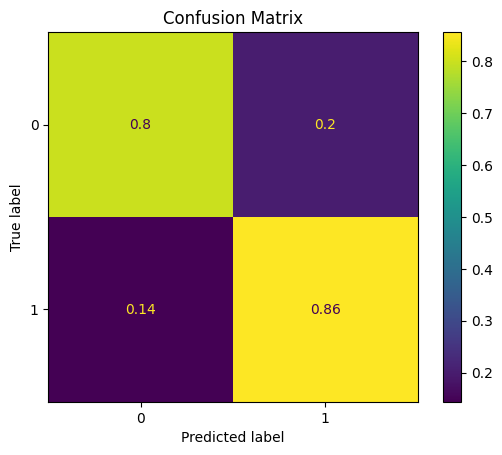

              precision    recall  f1-score   support

           0       0.85      0.80      0.82       462
           1       0.81      0.86      0.83       459

    accuracy                           0.83       921
   macro avg       0.83      0.83      0.83       921
weighted avg       0.83      0.83      0.83       921



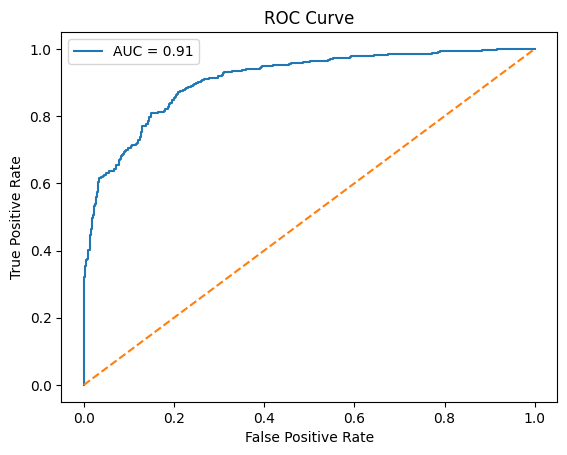

In [31]:
y_pred_crops, y_pred_prob_crops = evaluate_classifier(model, x_test_vid, y_test_aug)

#### 7. Majority vote to trial level and report metrics

Number of crop labels: 921
Number of trial-level labels: 307
Trial-level accuracy: 0.9022801302931596
Trial-level F1 score: 0.9050632911392406


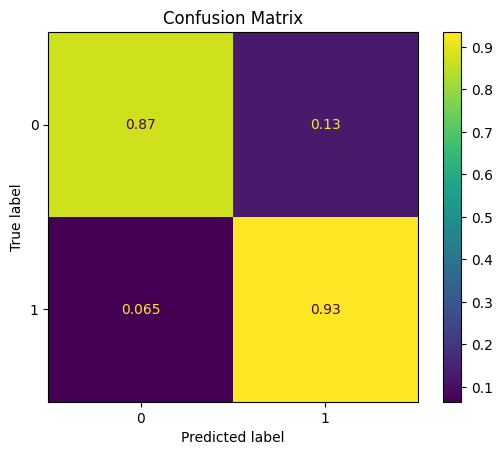

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       154
           1       0.88      0.93      0.91       153

    accuracy                           0.90       307
   macro avg       0.90      0.90      0.90       307
weighted avg       0.90      0.90      0.90       307



In [32]:
y_trial_pred = majority_vote_over_crops(y_pred_crops, factor=factor)

print("Trial-level accuracy:", accuracy_score(y_test, y_trial_pred))
print("Trial-level F1 score:", f1_score(y_test, y_trial_pred))

plot_confusion_matrix(y_test, y_trial_pred)